In [36]:
import os 
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from skimage import segmentation, color, graph
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


In [37]:
TRAIN_DATA_DIR = "data/train"
CLASS_DICT = "data/class_dict.csv"

class_df = pd.read_csv(CLASS_DICT)
class_rgb_values = class_df[['r', 'g', 'b']].values.tolist()
class_names = class_df['name'].tolist()
n_classes = len(class_names)

# original images are 2448x2448. we can use these constants to control their scaling.
IMG_HEIGHT, IMG_WIDTH = 512, 512

In [38]:
class DeepGlobeDataset(Dataset):
    def __init__(self, data_dir, class_rgb_values, img_size):
        self.image_paths = sorted(glob(os.path.join(data_dir, '*_sat.jpg')))
        self.mask_paths  = sorted(glob(os.path.join(data_dir, '*_mask.png')))
        self.class_rgb_values = class_rgb_values
        self.img_size = img_size  # (W, H)
        self.img_to_tensor = T.ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # --- Load & resize image ---
        img = Image.open(self.image_paths[idx]).convert('RGB')
        img = img.resize(self.img_size, resample=Image.Resampling.BILINEAR)

        # --- Load & resize mask ---
        mask = Image.open(self.mask_paths[idx]).convert('RGB')
        mask = mask.resize(self.img_size, resample=Image.Resampling.NEAREST)

        img_t = self.img_to_tensor(img)   # float32, (3,H,W) in [0,1]

        mask_np = np.array(mask)                   # (H,W,3), uint8
        mask_np = self.rgb_to_class(mask_np)  # (H,W), uint8
        mask_t = torch.from_numpy(mask_np).long()  # (H,W), int64

        return img_t, mask_t
    
    def rgb_to_class(self, mask):
        """
        Convert (H, W, 3) RGB mask to (H, W) class-index mask.
        """
        semantic_map = np.zeros(mask.shape[:2], dtype=np.uint8)
        for idx, color in enumerate(self.class_rgb_values):
            semantic_map[np.all(mask == color, axis=-1)] = idx
        return semantic_map


In [39]:
dataset = DeepGlobeDataset(
    data_dir=TRAIN_DATA_DIR,
    class_rgb_values=class_rgb_values,
    img_size=(IMG_WIDTH, IMG_HEIGHT),
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=(device.type=="cuda"))


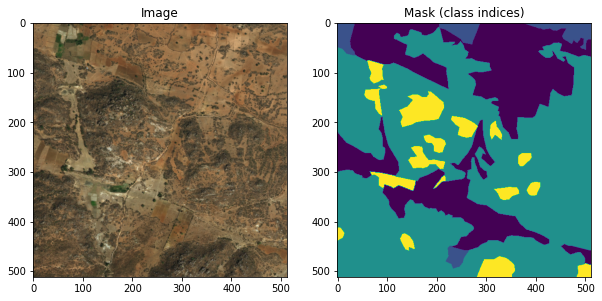

In [40]:
# example visualization 
images,masks = next(iter(loader))
img = images[0].permute(1, 2, 0).cpu().numpy()  # (H, W, 3)
mask = masks[0].cpu().numpy()                   # (H, W)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Image")


plt.subplot(1,2,2)
plt.imshow(mask)  # categorical mask
plt.title("Mask (class indices)")
plt.show()

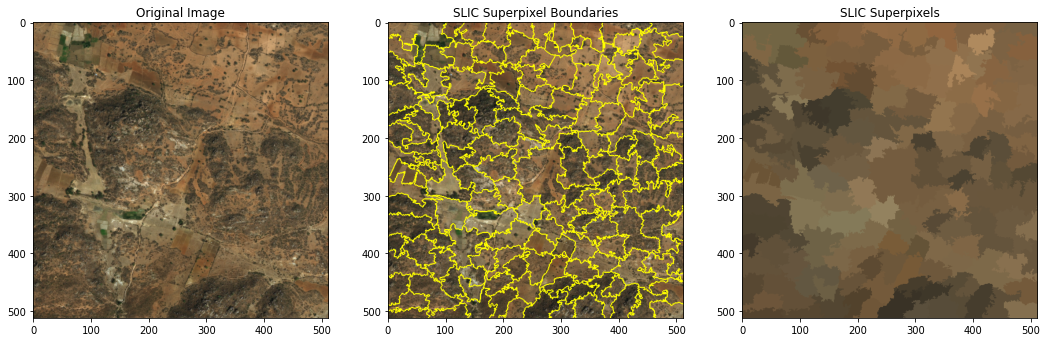

In [41]:
K = 200
segments = segmentation.slic(img, n_segments=K, compactness=10, start_label=1)
n_nodes = segments.max()

# Visualize SLIC result
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(img)
ax[0].set_title("Original Image")

ax[1].imshow(segmentation.mark_boundaries(img, segments))
ax[1].set_title("SLIC Superpixel Boundaries")

ax[2].imshow(color.label2rgb(segments, img, kind='avg'))
ax[2].set_title("SLIC Superpixels")

plt.show()

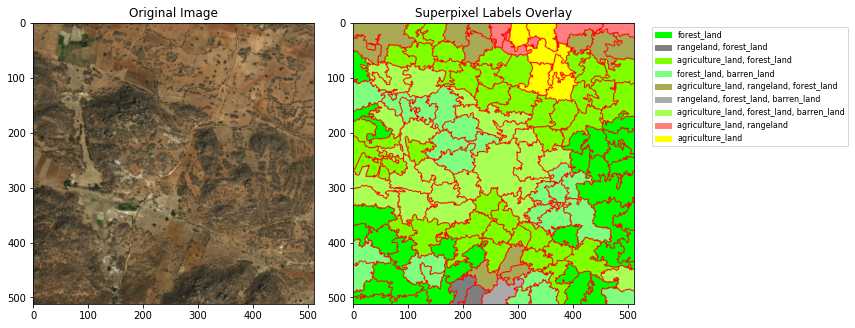

In [ ]:
labels = np.zeros((n_nodes, n_classes), dtype=np.uint8)

for i in range(1, n_nodes + 1):
    region_mask = (segments == i)
    region_classes = np.unique(mask[region_mask])
    for c in region_classes:
        labels[i - 1, c] = 1

# Compute colors for superpixels
sp_colors = np.zeros((n_nodes, 3), dtype=np.uint8)
sp_label_combos = []  # store class names for each superpixel
for i in range(n_nodes):
    present_classes = np.where(labels[i] == 1)[0]
    sp_colors[i] = np.mean([class_rgb_values[c] for c in present_classes], axis=0)
    sp_label_combos.append([class_names[c] for c in present_classes])

# Create an image where each pixel gets its superpixel color
color_img = np.zeros_like(img, dtype=np.uint8)
for i in range(1, n_nodes + 1):
    color_img[segments == i] = sp_colors[i-1]


# Plot original image, mask, and superpixel labels
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[0].set_title("Original Image")

ax[1].imshow(segmentation.mark_boundaries(color_img, segments, (0, 0, 0)))
ax[1].set_title("Superpixel Labels Overlay")

# --- Add legend for superpixel colors ---
unique_colors, unique_indices = np.unique(sp_colors, axis=0, return_index=True)
patches = []
for idx in unique_indices:
    label_colors = sp_colors[idx] / 255  
    label_text = ", ".join(sp_label_combos[idx])
    patches.append(mpatches.Patch(color=label_colors, label=label_text))

ax[1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

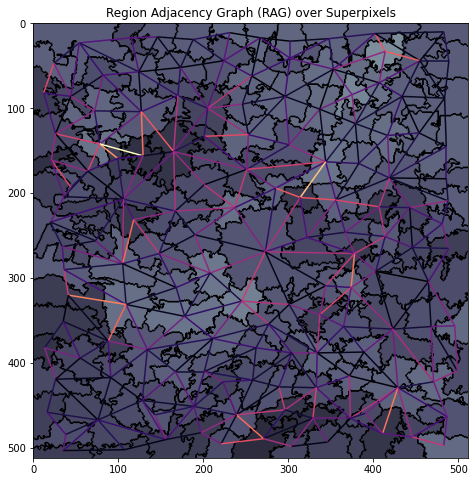

In [43]:
rag = graph.rag_mean_color(img, segments)
edges = np.array(list(rag.edges))

out = color.label2rgb(segments, img, kind='avg', bg_label=0)

# Draw RAG edges on top
fig, ax = plt.subplots(figsize=(8, 8))
graph.show_rag(segments, rag, out, ax=ax)
ax.set_title("Region Adjacency Graph (RAG) over Superpixels")
plt.show()